# Background

We derive expressions for the survival probability, denoted as $S(u | \theta)$, that two loci separated by $u$ units share the same most recent common ancestor for a pair of individuals, given a demographic model with parameters $\theta$.

## Under SMC

In [1]:
from sympy import *
init_printing()

Nec = Symbol('N_c', positive=True) # Contemporary diploid population size
alpha = Symbol('alpha', nonzero=True) # Growing rate
t = Symbol('t', positive=True) # Time
Ne = Nec * exp(-t*alpha)
Eq(symbols('N_{c}(t|\\theta)'), Ne) # Diploid population size

In [2]:
u = Symbol('u', positive=True) # Distance (Morgan)
x = Symbol('x', positive=True) # Placeholder
gamma = 1 / (2*Ne) # Coalescent rate
Gamma = integrate(gamma,(x, 0, t)) # Cumulative coalescent rate
tmrca = gamma * exp(-Gamma)
# TMRCA density
Eq(symbols('f(t|\\theta)'), tmrca)

In [3]:
# Under SMC, each recombination changes ancestry
Eq(symbols('S(u|t)'), exp(-2*t*u))

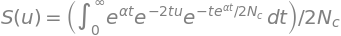

In [4]:
# Survival density for distance exactly equal to u
survival = integrate(exp(-2*t*u) * tmrca, (t, 0, oo))
Eq(symbols('S(u)'), survival.simplify())

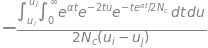

In [5]:
# Survival density for distance exactly equal to u
ui = Symbol('u_i', positive=True) # Distance (Morgan)
uj = Symbol('u_j', positive=True) # Distance (Morgan)

uniform_dist = 1 / (uj - ui)
survival_bin = integrate(survival * uniform_dist, (u, ui, uj)).simplify()
survival_bin

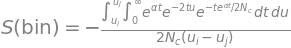

In [6]:
Eq(symbols('S(\\text{bin})'), survival_bin)

# Approximate SMC'


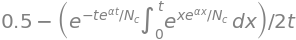

In [7]:
# Probability of healing event
ph = 0.5 - exp(-2*Gamma) / (2*t) * integrate(exp(2*Gamma.subs({t: x})), (x, 0, t))
ph

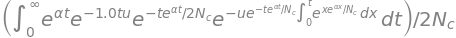

In [8]:
integrate(exp(-2*t*u*(1-ph)) * tmrca, (t, 0, oo))

We can obtain a more tractable expression by considering only $k=1$ healing events: 

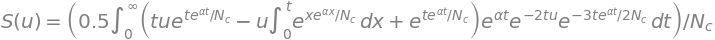

In [9]:
# Erlang PDF for k=1
v = symbols('v', real=True, positive=True)
f_erl_1 = (2*t) * exp(-2*t*v)
S_ut = exp(-2*u*t) + ph * integrate(f_erl_1 * exp(-2*t*(u-v)), (v, 0, u))
survival2 = integrate(S_ut * tmrca, (t, 0, oo))
Eq(symbols('S(u)'), survival2.simplify())

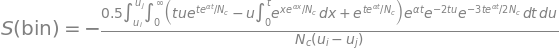

In [10]:
survival_bin2 = integrate(survival2 * uniform_dist, (u, ui, uj)).simplify()
Eq(symbols('S(\\text{bin})'), survival_bin2)

We haven't found closed-form expressions for $S(u)$. However, we found reasonably good numerical approximations using Gaussian quadrature rules under SMC